In [1]:
import talib
from pandas import DataFrame, read_csv, concat
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU
from keras.callbacks import EarlyStopping,Callback
from keras import backend
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = read_csv('BTCHourlyData.csv', parse_dates = ['timestamp'], usecols = ['timestamp', 'c']).fillna(method='ffill')

In [3]:
sma = talib.SMA(data['c'], timeperiod = 5)
ema = talib.EMA(data['c'], timeperiod = 5)
macd = talib.MACD(data['c'])[0]
rsi = talib.RSI(data['c'])
mom = talib.MOM(data['c'], timeperiod = 9)
y = data['c'][33:]

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_mape', value=1, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)        
            
        if epoch>5:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            if current < self.value:                
                self.model.stop_training = True

In [6]:
features = DataFrame()
features['sma'] = sma[33:]
features['ema'] = ema[33:]
features['macd'] = macd[33:]
features['rsi'] = rsi[33:]
features['mom'] = mom[33:]
features['y'] = y

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(features)
scaled = scaler.fit_transform(features)

In [92]:
n = 1
series = series_to_supervised(scaled, n, n+1)
dropColumns = []
for i in range(scaled.shape[1]-1):
    dropColumns.append('var{}(t+{})'.format(i+1,n))
reframed = series.drop(columns=dropColumns)

In [137]:
split = int(0.7*reframed.shape[0])
train_X, test_X = reframed.values[:split,:-1], reframed.values[split:,:-1]
train_y, test_y = reframed.values[:split,-1], reframed.values[split:,-1]
#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [148]:
#Cocco et al. (2021) model
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
callbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=0.4, verbose=2)]
history = model.fit(train_X, train_y, epochs = 50, batch_size = 512, validation_data=(test_X, test_y), verbose = 2, shuffle = False, callbacks=  callbacks)

Epoch 1/50
134/134 - 3s - loss: 2.5098e-04 - mape: 0.6262 - val_loss: 0.0237 - val_mape: 10.3809
Epoch 2/50
134/134 - 1s - loss: 8.7186e-04 - mape: 1.5897 - val_loss: 0.0185 - val_mape: 10.2194
Epoch 3/50
134/134 - 1s - loss: 0.0010 - mape: 1.7582 - val_loss: 0.0105 - val_mape: 7.0417
Epoch 4/50
134/134 - 1s - loss: 5.6179e-04 - mape: 1.2900 - val_loss: 0.0035 - val_mape: 4.2958
Epoch 5/50
134/134 - 1s - loss: 2.2241e-04 - mape: 0.8097 - val_loss: 5.9064e-04 - val_mape: 2.0355
Epoch 6/50
134/134 - 1s - loss: 6.2626e-05 - mape: 0.4239 - val_loss: 8.4608e-05 - val_mape: 0.8033
Epoch 7/50
134/134 - 1s - loss: 1.3426e-05 - mape: 0.1945 - val_loss: 8.8589e-05 - val_mape: 0.5964
Epoch 00006: early stopping THR
Epoch 8/50
134/134 - 1s - loss: 3.9937e-06 - mape: 0.1084 - val_loss: 1.0311e-04 - val_mape: 0.5302
Epoch 00007: early stopping THR
Epoch 9/50
134/134 - 1s - loss: 2.3497e-06 - mape: 0.0831 - val_loss: 9.8518e-05 - val_mape: 0.4918
Epoch 00008: early stopping THR
Epoch 10/50
134/134 - 

In [149]:
model_prediction = model.predict(test_X)
actualValues = np.array(y[-len(model_prediction):]).reshape(-1,1)
scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scalerCrypto.fit(actualValues)
scaledCrypto = scalerCrypto.fit_transform(actualValues)
model_prediction_unscale = scalerCrypto.inverse_transform(model_prediction)
predictedValues = np.reshape(model_prediction_unscale, model_prediction_unscale.shape[0])
actualValues = np.reshape(actualValues, actualValues.shape[0])

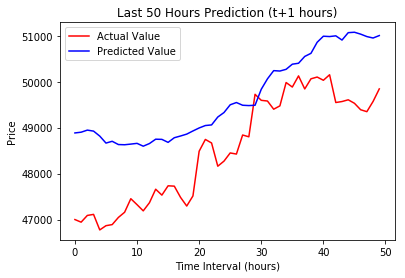

In [150]:
frm=-50
plt.plot(actualValues[frm:], color = 'red', label = 'Actual Value')
plt.plot(predictedValues[frm:], color = 'blue', label = 'Predicted Value') 
plt.title('Last {} Hours Prediction (t+{} hours)'.format(-frm, n))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

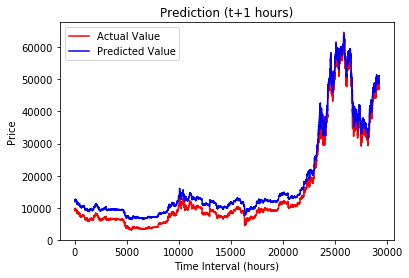

In [151]:
plt.plot(actualValues, color = 'red', label = 'Actual Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Value')
plt.title('Prediction (t+{} hours)'.format(n))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

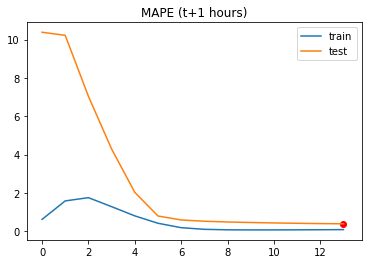

Best MAPE = 0.3963572084903717


In [152]:
plt.title('MAPE (t+{} hours)'.format(n))
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='test')
plt.scatter(np.argmin(history.history['val_mape']), min(history.history['val_mape']), color = 'r')
plt.legend()
plt.show()
print('Best MAPE = '+str(min((history.history['val_mape']))))

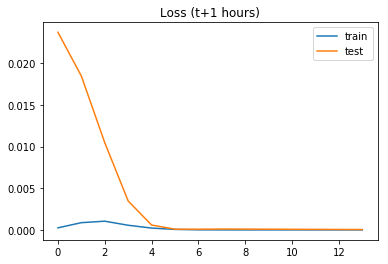

In [153]:
plt.title('Loss (t+{} hours)'.format(n))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [154]:
result_value=[]

for n_percent in range(3):
    actual_delta = []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0
    profit = []
    profit_agg = 0
    
    for i in range(2, len(actualValues) - 4):
        a_delta = (actualValues[i + 1] - actualValues[i]) / actualValues[i + 1]
        p_delta = (predictedValues[i + 1] - predictedValues[i]) / predictedValues[i + 1]

        if p_delta > 0 and a_delta > 0 and abs(p_delta)*100>n_percent:
            correct_long += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta > 0 > a_delta and abs(p_delta)*100>n_percent:
            incorrect_long += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta < 0 and a_delta < 0 and abs(p_delta)*100>n_percent:
            correct_short += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta < 0 < a_delta and abs(p_delta)*100>n_percent:
            incorrect_short += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            
    long_p=correct_long/(correct_long+incorrect_short)*100
    short_p=correct_short/(correct_short+incorrect_long)*100
    total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
    print('Analyzer 2 - Percent: ',n_percent)
    print("------------")
    print('LONG VALUES')
    print('correct_long', correct_long)
    print('incorrect_short', incorrect_short)
    print('correct_long_percentage', round(long_p,2))
    print('')
    print('SHORT VALUES')
    print('correct_short', correct_short)
    print('incorrect_long', incorrect_long)
    print('correct_short_percentage', round(short_p,2))
    print('')
    print('TOTAL')
    print('total_correct',correct_short+correct_long)
    print('total_incorrect',incorrect_long+incorrect_short )
    print('correct_total_percentage', round(total_correct,2))
    print('profit_tracker', round(profit_agg,2))
    print()
    print('########################################################')
    print()
        
    st='LONG VALUES\n\ncorrect_long: {}\nincorrect_short: {}\ncorrect_long_percentage: {}\n\nSHORT VALUES\n\ncorrect_short: {}\nincorrect_long: {}\ncorrect_short_percentage: {}\n\nTOTAL\n\ntotal_correct: {}\ntotal_incorrect: {}\ncorrect_total_percentage: {}\nprofit_tracker: {}'.format(correct_long,incorrect_short,long_p,correct_short,incorrect_long,short_p,correct_short+correct_long,incorrect_long+incorrect_short,total_correct,profit_agg)
    result_value.append(st)

Analyzer 2 - Percent:  0
------------
LONG VALUES
correct_long 7472
incorrect_short 7503
correct_long_percentage 49.9

SHORT VALUES
correct_short 6369
incorrect_long 7842
correct_short_percentage 44.82

TOTAL
total_correct 13841
total_incorrect 15345
correct_total_percentage 47.42
profit_tracker 31169.75

########################################################

Analyzer 2 - Percent:  1
------------
LONG VALUES
correct_long 65
incorrect_short 87
correct_long_percentage 42.76

SHORT VALUES
correct_short 68
incorrect_long 52
correct_short_percentage 56.67

TOTAL
total_correct 133
total_incorrect 139
correct_total_percentage 48.9
profit_tracker -1216.77

########################################################

Analyzer 2 - Percent:  2
------------
LONG VALUES
correct_long 0
incorrect_short 6
correct_long_percentage 0.0

SHORT VALUES
correct_short 8
incorrect_long 1
correct_short_percentage 88.89

TOTAL
total_correct 8
total_incorrect 7
correct_total_percentage 53.33
profit_tracker -1105.

In [155]:
model_json = model.to_json()
with open('BTCt+1_model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('BTCt+1_model.h5')
print('Saved BTCt+1_model.h5 to disk')

Saved BTCt+1_model.h5 to disk
